## Langgraph:
Langgraph is a library for building stateful , multi-actor application with LLM, used to create agent and multi-agent workflows. Compared to other framework it offers these core benifits : cycles, controlability and persistance. Langgraph allows you to define flows that involve cycles, essential for most agentic architectures, differentiating it from DAG based solutions. 

#### Why Langgraph:
- Simplify the development :- Stage Management and agent coordination when we are working with multi-AI agent.Let say I wanted to build an chatbot which does wiki , arxiv and vector DB search. In this system we need highest degree of stage management , agent coordination. 
- Flexibility :- With Langgraph , developers have the flexibility to define their own agentic logic and communication protocol. This allows for highly customized applications tailored to specific use-case. Whether you need a chatbot that requires to handle various types of user requests or multi-agent system that performs the complex task, Langgraph provides the advantage what you need. 
- Scalability  - we can build the large scale multi-agent application.
- Fault Tolerance - handle errors and does fault tolerance which means langgraph has high reliability.
- 

## What is Langgraph 
- Langgraph is a orchestration framework for builidig intelligent , stateful and multistep LLM workflows.
- It enables advanced features like parralization, loop, branching, memory and resumability.
- It models your logic as a graph of a nodes (task) and edges (routing) instead of linear chain.

## What is LLM workflows 
- LLM workflows is a step by step process using which we can build complex LLM application.
- Each step perform distict task like prompting, reasoning , tools calling, memory access, decision making.
- workflows can linear, branched, paralled or looped, allowing for complex behaviours like retries, multiagent communication and tools agumented reasoning.
- Here is different workflows like prompting, routing, parallization, orchestration, evaluator optimizer. 

In [11]:
from langgraph.graph import StateGraph

from typing_extensions import TypedDict


class BMIState(TypedDict):
    wight: float  # in kg
    height: float  # in meters
    bmi_value: float


graph = StateGraph(BMIState)


def calculate_bmi(state: BMIState) -> dict:
    weight = state["wight"]
    height = state["height"]
    bmi = weight / (height**2)
    state["bmi_value"] = bmi
    return state


graph.add_node("calculate_bmi", calculate_bmi)
from langgraph.graph import START, END

graph.add_edge(START, "calculate_bmi")
graph.add_edge("calculate_bmi", END)
bmi_calculator_workflow = graph.compile()
result = bmi_calculator_workflow.invoke({"wight": 70, "height": 1.75})
print(f"BMI Calculation Result: {result}")

BMI Calculation Result: {'wight': 70, 'height': 1.75, 'bmi_value': 22.857142857142858}


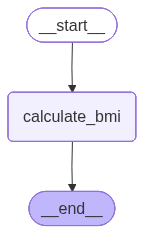

In [12]:
from IPython.display import Image

Image(bmi_calculator_workflow.get_graph().draw_mermaid_png())

## Conditinal workflows

In [ ]:
from ast import literal_eval
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict, Literal
from dotenv import load_dotenv
import os
from langchain_openai import ChatOpenAI

openai_client = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    api_key=os.getenv("OPENAI_API_TOKEN"),
    base_url=os.getenv("OPENAI_API_BASE"),
)
from pydantic import BaseModel, Field


class DetectSentiment(BaseModel):
    sentiment_type: Literal["positive", "negative"] = Field(
        ..., description="The sentiment type of the text."
    )


## sentiment detection model
sentiment_detection_model = openai_client.with_structured_output(DetectSentiment)

prompt = "What is the sentiment of the following review? 'I absolutely love this product! It has changed my life for the better."
response = sentiment_detection_model.invoke(prompt)
print(f"Response from sentiment detection model: {response.sentiment_type}")


class ReviewState(TypedDict):
    review_text: str
    sentiment: Literal["positive", "negative"]
    diagnosis: str
    response: str


def detect_setiment(state: ReviewState) -> ReviewState:
    prompt = f"What is the sentiment of the following review? '{state['review_text']}'"
    response = sentiment_detection_model.invoke(prompt)
    state["sentiment"] = response.sentiment_type
    return state


def check_sentiment(
    state: ReviewState,
) -> Literal["positive_response", "run_diagnosis"]:
    if state["sentiment"] == "positive":
        return "positive_response"
    else:
        return "run_diagnosis"


def positive_response(state: ReviewState) -> ReviewState:
    prompt = f"write a warm thank-you message in response to the following positive review: '{state['review_text']}'"
    response = openai_client.invoke(prompt)
    state["response"] = response.content
    return state


class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(
        ..., description="The type of issue mentioned in the review."
    )
    tone: Literal["Angry", "Frustrated", "Disappointed", "Neutral"] = Field(
        ..., description="The tone of the review."
    )
    urgency: Literal["Low", "Medium", "High", "Critical"] = Field(
        ..., description="The urgency level of the issue mentioned in the review."
    )


diagnosis_model = openai_client.with_structured_output(DiagnosisSchema)


def run_diagnosis(state: ReviewState) -> ReviewState:
    prompt = f"Analyze the negative reivew {state['review_text']} and return issue type , tone and ugency."
    response = diagnosis_model.invoke(prompt)
    state["diagnosis"] = response.model_dump()
    return state


def negative_response(state: ReviewState) -> ReviewState:
    prompt = f"The user had a {state['diagnosis']['issue_type']} issue. The tone of the review is {state['diagnosis']['tone']}. The urgency of the issue is {state['diagnosis']['urgency']}. Write a empathetic , helpful resolution message in response to the following negative review: '{state['review_text']}'"
    response = openai_client.invoke(prompt)
    state["response"] = response.content
    return state


sentiment_graph = StateGraph(state_schema=ReviewState)
sentiment_graph.add_node("detect_sentiment", detect_setiment)
sentiment_graph.add_node("positive_response", positive_response)
sentiment_graph.add_node("run_diagnosis", run_diagnosis)
sentiment_graph.add_node("negative_response", negative_response)
sentiment_graph.add_edge(START, "detect_sentiment")
sentiment_graph.add_conditional_edges("detect_sentiment", check_sentiment)
sentiment_graph.add_edge("positive_response", END)
sentiment_graph.add_edge("run_diagnosis", "negative_response")
sentiment_graph.add_edge("negative_response", END)

sentiment_workflow = sentiment_graph.compile()
Image(sentiment_workflow.get_graph().draw_mermaid_png())


result = sentiment_workflow.invoke(
    {
        "review_text": "I absolutely love this product! It has changed my life for the better."
    }
)
print(f"Response from sentiment detection model: {result['response']}")

# test with one negative comment

result = sentiment_workflow.invoke(
    {
        "review_text": "I absolutely hate this product! It has changed my life for the worse."
    }
)
print(f"Response from sentiment detection model: {result['response']}")

Response from sentiment detection model: positive
Response from sentiment detection model: Dear [Reviewer's Name],

Thank you so much for your wonderful feedback! We are thrilled to hear that our product has made such a positive impact on your life. Your kind words truly mean the world to us and inspire us to continue delivering the best for our customers. 

If you ever have any questions or need further assistance, please don't hesitate to reach out. We're here for you!

Warm regards,

[Your Name]  
[Your Company]
Response from sentiment detection model: I'm truly sorry to hear about your experience with our product. It’s concerning to us that it has had such a negative impact on your life, and I want to assure you that we take your feedback very seriously. Our goal is to provide products that enhance our customers' lives, and it’s clear we’ve fallen short in your case.

Please reach out to our customer support team at your earliest convenience so we can better understand the issues y